In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import construct_templates, compute_Cells_from_map, compute_Cells
import dipole
from jackknife import get_longitude_subsamples, compute_jackknife_uncertainty

In [3]:
# healpix resolution
NSIDE = 64

### CatWISE

In [4]:
# instantiate a dipole object and load the source density table - NOT corrected by the selection function
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                    blim=30, maglim=16.4, load_init=True)
d = SecrestDipole(**catwise_kwargs)
d.cut_mag()
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
map_S21 = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

loading initial catalog, catwise_agns_master.fits
8532854 sources in initial catalog.
cut w1 > 16.4 -> 3079981 sources left.


In [5]:
# ecliptic latitudes of each HEALPIXEL
elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat

In [6]:
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_S21)
p = np.polyfit(np.abs(elat)[idx], map_S21[idx], deg=1)

In [7]:
p

array([-4.14916266e-02,  5.77477631e+01])

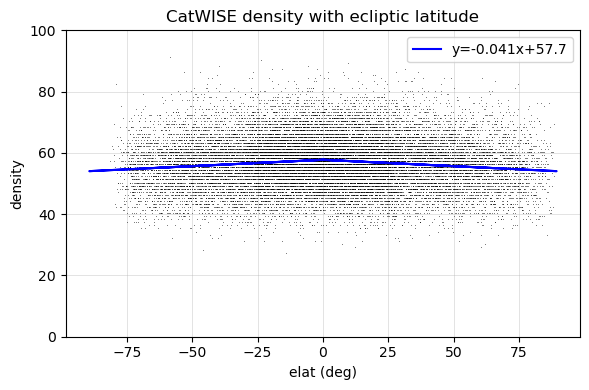

In [8]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(elat, map_S21, ls='None', marker=',', c='k', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')
ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('elat (deg)')
ax.set_ylabel('density')
ax.set_title('CatWISE density with ecliptic latitude')
ax.legend()

In [9]:
# correct the densities and fit to the corrected densities
map_S21_elatcorr = map_S21 - np.polyval(p, np.abs(elat.value)) + p[1]

p_corr = np.polyfit(np.abs(elat)[idx], map_S21_elatcorr[idx], deg=1)

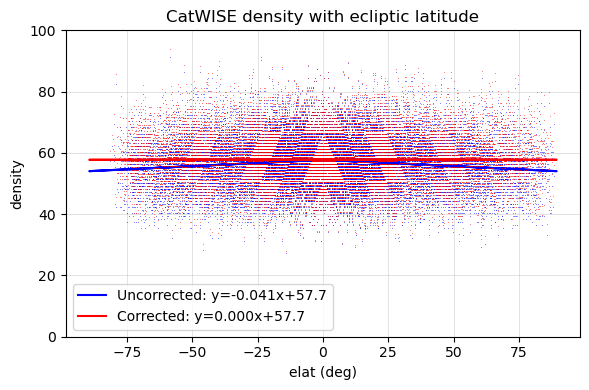

In [10]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
# uncorrected
ax.plot(elat, map_S21, ls='None', marker=',', c='b', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b',
        label=f'Uncorrected: y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

# corrected
ax.plot(elat, map_S21_elatcorr, ls='None', marker=',', c='r', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr[0] + p_corr[1], c='r',
        label=f'Corrected: y={p_corr[0]:.3f}x+{p_corr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr[0] + p_corr[1], c='r')

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('elat (deg)')
ax.set_ylabel('density')
ax.set_title('CatWISE density with ecliptic latitude')
ax.legend()

### Quaia

In [11]:
# Quaia

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False)
d = SecrestDipole(**quaia_kwargs)
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)
mean, std = np.nanmean(datamap), np.nanstd(datamap)

# and load selection function
selfunc = d.load_selfunc()

# delete the tables to clear up memory !
del d.initial_cattab
del d.table

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
map_quaia = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.


In [12]:
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_quaia)
p = np.polyfit(np.abs(elat)[idx], map_quaia[idx], deg=1)

In [13]:
p

array([ 0.03971989, 20.46833413])

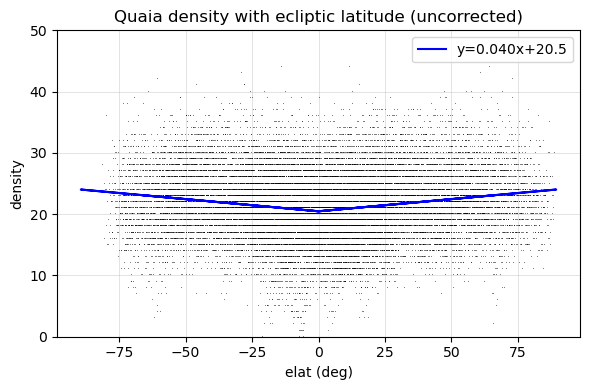

In [14]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(elat, map_quaia, ls='None', marker=',', c='k', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')
ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 50)
ax.set_xlabel('elat (deg)')
ax.set_ylabel('density')
ax.set_title('Quaia density with ecliptic latitude (uncorrected)')
ax.legend()

In [15]:
# now correct by selection function and refit
map_quaia_compcorr = map_quaia / selfunc

idx = ~np.isnan(elat) & ~np.isnan(map_quaia_compcorr)
p_compcorr = np.polyfit(np.abs(elat)[idx], map_quaia_compcorr[idx], deg=1)

/state/partition1/job-44523462/ipykernel_1969212/4113364638.py:2: RuntimeWarning: invalid value encountered in divide
  map_quaia_compcorr = map_quaia / selfunc


In [16]:
p_compcorr

array([-2.24304711e-03,  3.37084130e+01])

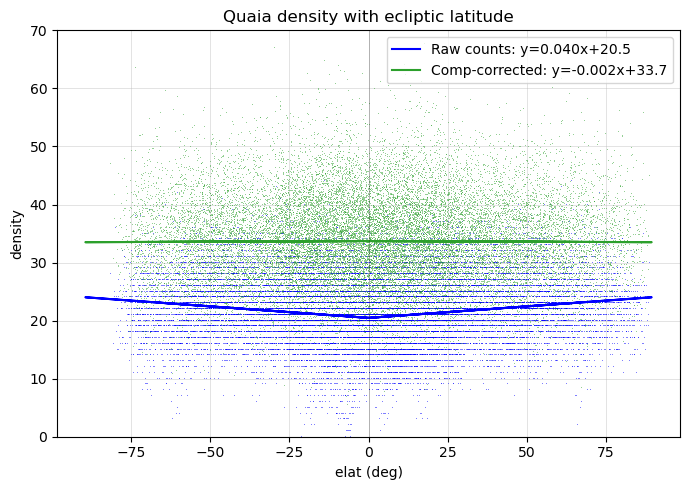

In [17]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(elat, map_quaia, ls='None', marker=',', c='b', alpha=0.5)
ax.plot(elat, map_quaia_compcorr, ls='None', marker=',', c='C2', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b',
        label=f'Raw counts: y={p[0]:.3f}x+{p[1]:.1f}')
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_compcorr[0] + p_compcorr[1], c='C2',
        label=f'Comp-corrected: y={p_compcorr[0]:.3f}x+{p_compcorr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_compcorr[0] + p_compcorr[1], c='C2')
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.3, lw=0.5)
ax.set_ylim(0, 70)
ax.set_xlabel('elat (deg)')
ax.set_ylabel('density')
ax.set_title('Quaia density with ecliptic latitude')
ax.legend()

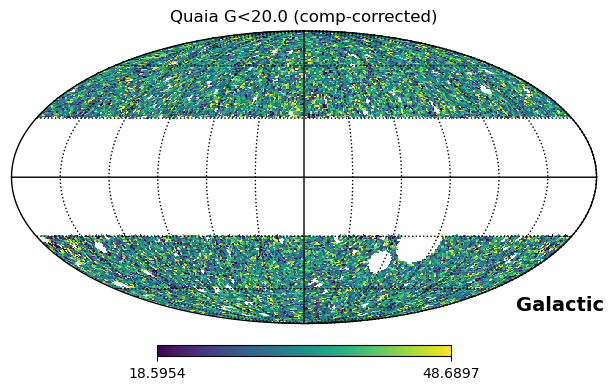

In [18]:
mean, std = np.nanmean(map_quaia_compcorr), np.nanstd(map_quaia_compcorr)
fig = plt.figure(figsize=(12,4))
hp.mollview(map_quaia_compcorr, fig=fig, sub=(1,2,1), coord=['C','G'], badcolor='w', min=mean-2*std, max=mean+2*std,
            title='Quaia G<20.0 (comp-corrected)')
hp.graticule()

In [19]:
# correct the densities and fit to the corrected densities
map_quaia_elatcorr = map_quaia_compcorr - np.polyval(p_compcorr, np.abs(elat.value)) + p_compcorr[1]

p_corr = np.polyfit(np.abs(elat)[idx], map_quaia_elatcorr[idx], deg=1)

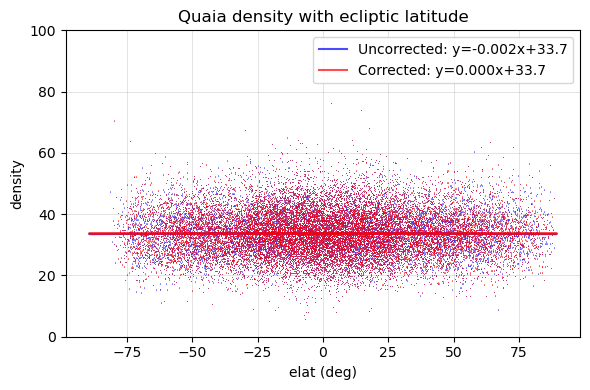

In [20]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
# uncorrected
ax.plot(elat, map_quaia_compcorr, ls='None', marker=',', c='b', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_compcorr[0] + p_compcorr[1], c='b', alpha=0.7,
        label=f'Uncorrected: y={p_compcorr[0]:.3f}x+{p_compcorr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_compcorr[0] + p_compcorr[1], c='b', alpha=0.7)

# corrected
ax.plot(elat, map_quaia_elatcorr, ls='None', marker=',', c='r', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr[0] + p_corr[1], c='r', alpha=0.7,
        label=f'Corrected: y={p_corr[0]:.3f}x+{p_corr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr[0] + p_corr[1], c='r', alpha=0.7)

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('elat (deg)')
ax.set_ylabel('density')
ax.set_title('Quaia density with ecliptic latitude')
ax.legend()

### measure dipole in corrected vs. uncorrected catalog

In [21]:
# get overdensity maps

# CATWISE
# uncorrected
overdensity_map_S21_uncorr = map_S21 / np.nanmean(map_S21) - 1
# corrected
overdensity_map_S21_corr = map_S21_elatcorr / np.nanmean(map_S21_elatcorr) - 1

# QUAIA
# uncorrected
overdensity_map_quaia_uncorr = map_quaia_compcorr / np.nanmean(map_quaia_compcorr[selfunc>0]) - 1
# corrected:
overdensity_map_quaia_corr = map_quaia_elatcorr / np.nanmean(map_quaia_elatcorr[selfunc>0]) - 1

In [22]:
# expected amplitudes
cmb_dipamp_S21 = 0.007
cmb_dipamp_quaia = 0.005

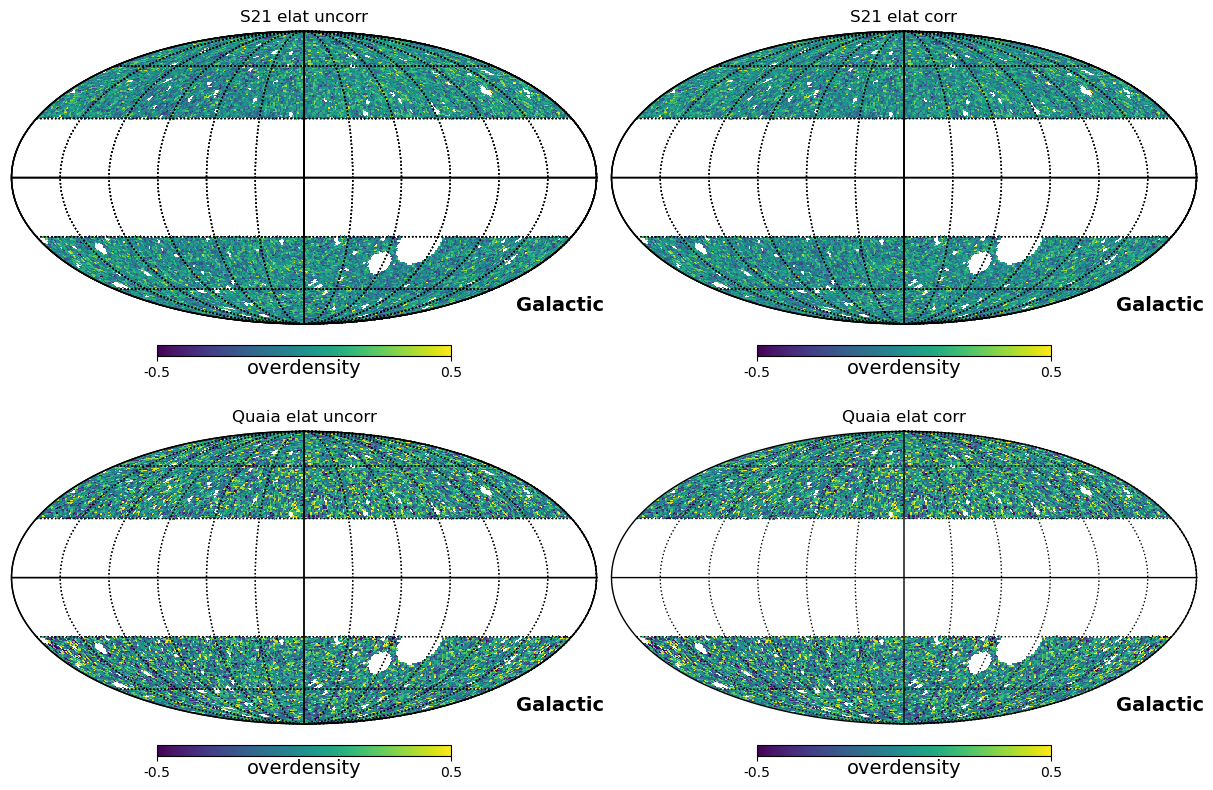

In [23]:
# plot overdensity maps
fig = plt.figure(figsize=(12,8))
titles = ['S21 elat uncorr', 'S21 elat corr', 'Quaia elat uncorr', 'Quaia elat corr']
for i, hpmap in enumerate([overdensity_map_S21_uncorr, overdensity_map_S21_corr, overdensity_map_quaia_uncorr, overdensity_map_quaia_corr]):
    hp.mollview(hpmap, coord=['C','G'], fig=fig, sub=(2,2,i+1), unit='overdensity', title=titles[i], min=-.5, max=.5, badcolor='w')
    hp.graticule()

In [24]:
# get the two main cases: 1) don't fit masked pixels at all, and 2) set masked pixels to zero with Cinv=1

# whether to fit zeros (regularize / include masked pixels in the fit)
fit_zeros = False

# CATWISE
print("CATWISE")
# Cinv=identity, fit_zeros=True
# uncorrected
print("uncorrected:")
map_to_fit = overdensity_map_S21_uncorr.copy()
map_to_fit[np.isnan(map_to_fit)] = 0.
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=np.ones_like(map_to_fit), fit_zeros=fit_zeros)
print(f"\tamps: {amps}\n\tbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"\texpected dipole amp. =\t{cmb_dipamp_S21:.5f}\n\tratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_S21:.4f}")
S21_uncorr_dipdir = dipole.get_dipole(amps, frame='icrs')[1]

# corrected
print("corrected:")
map_to_fit = overdensity_map_S21_corr.copy()
map_to_fit[np.isnan(map_to_fit)] = 0.
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=np.ones_like(map_to_fit), fit_zeros=fit_zeros)
print(f"\tamps: {amps}\n\tbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"\texpected dipole amp. =\t{cmb_dipamp_S21:.5f}\n\tratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_S21:.4f}")
S21_corr_dipdir = dipole.get_dipole(amps, frame='icrs')[1]

# QUAIA
print("QUAIA")
# Cinv=selfunc, fit_zeros=False
# uncorrected
print("uncorrected:")
map_to_fit = overdensity_map_quaia_uncorr.copy()
idx_masked = np.isnan(map_to_fit)
map_to_fit[idx_masked] = 0.
Cinv = selfunc.copy()
Cinv[idx_masked] = 1
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv, fit_zeros=fit_zeros)
print(f"\tamps: {amps}\n\tbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"\texpected dipole amp. =\t{cmb_dipamp_quaia:.5f}\n\tratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_quaia:.4f}")
quaia_uncorr_dipdir = dipole.get_dipole(amps, frame='icrs')[1]

# corrected
print("corrected:")
map_to_fit = overdensity_map_quaia_corr.copy()
idx_masked = np.isnan(map_to_fit)
map_to_fit[idx_masked] = 0.
Cinv = selfunc.copy()
Cinv[idx_masked] = 1
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv, fit_zeros=fit_zeros)
print(f"\tamps: {amps}\n\tbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"\texpected dipole amp. =\t{cmb_dipamp_quaia:.5f}\n\tratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_quaia:.4f}")
quaia_corr_dipdir = dipole.get_dipole(amps, frame='icrs')[1]

CATWISE
uncorrected:
	amps: [ 7.70097306e-05 -1.24867252e-02  1.04018103e-02 -4.40991047e-03]
	best-fit dipole amp. =	0.01684
	expected dipole amp. =	0.00700
	ratio =			2.4056
corrected:
	amps: [ 2.49271833e-05 -1.15070845e-02  9.65426041e-03 -1.68322240e-03]
	best-fit dipole amp. =	0.01511
	expected dipole amp. =	0.00700
	ratio =			2.1592
QUAIA
uncorrected:
	amps: [-0.00016737 -0.01116305 -0.00656966 -0.008234  ]
	best-fit dipole amp. =	0.01535
	expected dipole amp. =	0.00500
	ratio =			3.0697
corrected:
	amps: [-0.00011593 -0.01102225 -0.006604   -0.00793272]
	best-fit dipole amp. =	0.01510
	expected dipole amp. =	0.00500
	ratio =			3.0201


In [25]:
# cmb
cmb_amp, cmb_dir = dipole.cmb_dipole(frame='galactic')

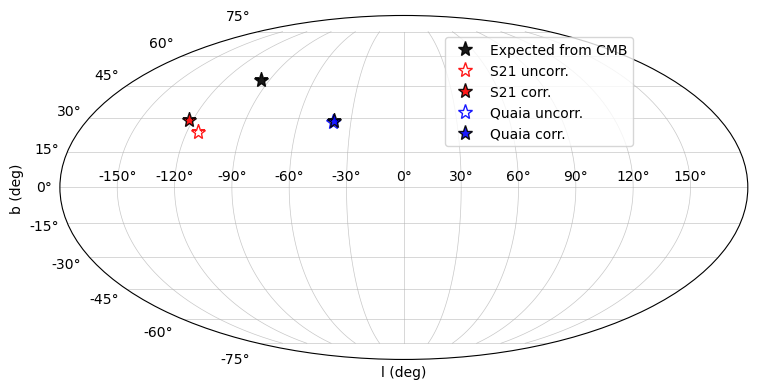

In [27]:
# sky plot
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111, projection='mollweide')

kwargs = dict(marker='*', ms=11, ls='None', alpha=0.9)

# CMB
ax.plot(Angle(cmb_dir.l, unit=u.rad).wrap_at(np.pi*u.rad),
        Angle(cmb_dir.b, unit=u.rad).wrap_at(np.pi*u.rad),
        c='k', label='Expected from CMB', mec='k', **kwargs)
# S21
ax.plot(Angle(S21_uncorr_dipdir.galactic.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(S21_uncorr_dipdir.galactic.b).to(u.rad).wrap_at(np.pi*u.rad),
        c='None', label='S21 uncorr.', mec='r', **kwargs)
ax.plot(Angle(S21_corr_dipdir.galactic.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(S21_corr_dipdir.galactic.b).to(u.rad).wrap_at(np.pi*u.rad),
        c='r', label='S21 corr.', mec='k', **kwargs)
# Quaia
ax.plot(Angle(quaia_uncorr_dipdir.galactic.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(quaia_uncorr_dipdir.galactic.b).to(u.rad).wrap_at(np.pi*u.rad),
        c='None', label='Quaia uncorr.', mec='b', **kwargs)
ax.plot(Angle(quaia_corr_dipdir.galactic.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(quaia_corr_dipdir.galactic.b).to(u.rad).wrap_at(np.pi*u.rad),
        c='b', label='Quaia corr.', mec='k', **kwargs)

ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.legend(loc=(.56,.62))
ax.grid(True, lw=0.5, alpha=0.7)
fig.tight_layout()